# DQNN Algorithm Tutorial

# Basic Imports

In [1]:
import gymnasium as gym
from tqdm.notebook import trange
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from collections import deque
import pandas as pd

## The Environment — Process Model

In [89]:
def take_action(env, action):
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    # --
    x = state[0] / 4.8
    theta = state[2] / 2.1
    reward *= (1-x**2) * (1-theta**2)
    # --
    return state, reward, done

## Decision Policies

In [90]:
def compute_epsilon(epsilon_current, delta_epsilon, epsilon_min):
    epsilon_new = epsilon_current - delta_epsilon
    if epsilon_new < epsilon_min:
        epsilon_new = epsilon_min
    return epsilon_new

In [91]:
def choose_action(model, state, epsilon):
    q_values = model(torch.from_numpy(state).float())
    q_values_ = q_values.data.numpy()
    if random.random() < epsilon:
        action = np.random.randint(0, 2)
    else:
        action = np.argmax(q_values_)
    return action, q_values

## Loss

In [92]:
def compute_loss(loss_function, model, experience, discounting_factor, minibatch_size):
    if len(experience) >= minibatch_size:
        minibatch = random.sample(experience, minibatch_size)
        # states = torch.cat([s_ for (s_, a_, r_, new_s_, done_) in minibatch])
        states = torch.Tensor(np.vstack([s_ for (s_, a_, r_, new_s_, done_) in minibatch]))
        actions = torch.Tensor([a_ for (s_, a_, r_, new_s_, done_) in minibatch])
        rewards = torch.Tensor([r_ for (s_, a_, r_, new_s_, done_) in minibatch])
        # new_states = torch.cat([new_s_ for (s_, a_, r_, new_s_, done_) in minibatch])
        new_states = torch.Tensor(np.vstack([new_s_ for (s_, a_, r_, new_s_, done_) in minibatch]))
        done = torch.Tensor([done_ for (s_, a_, r_, new_s_, done_) in minibatch])

        q_values = model(states)
        with torch.no_grad():
            new_q_values = model(new_states)

        max_q_value = torch.max(new_q_values, dim=1)[0]
        target = (rewards + discounting_factor * (1 - done) * max_q_value).reshape(minibatch_size)
        predict = q_values.gather(dim=1, index=actions.long().unsqueeze(dim=1)).squeeze().reshape(minibatch_size)
        return loss_function(predict, target.detach())

In [93]:
def create_loss_and_optimizer(model, learning_rate):
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return loss_function, optimizer

## Q-Network

In [94]:
def create_q_network(h1_size=100, h2_size=50):
    return torch.nn.Sequential(
        torch.nn.Linear(4, h1_size),
        torch.nn.ReLU(),
        torch.nn.Linear(h1_size, h2_size),
        torch.nn.ReLU(),
        torch.nn.Linear(h2_size, 2))

In [95]:
def update_weights(optimizer, loss_value):
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

## Simulate One Episode (in Training and in Production Mode)

In [96]:
def run_episode_and_learn(env, model, loss_fn, optimizer, eps, duration, exp, batch_size, gamma):
    s, _ = env.reset()

    actions_taken = 0
    while True:
        actions_taken += 1
        a, q = choose_action(model, s, eps)
        new_s, r, terminate = take_action(env, a)

        terminate = terminate or \
                    (actions_taken == duration)

        exp.append((s, a, r, new_s, terminate))
        loss = compute_loss(loss_fn, model, exp, gamma, batch_size)
        if loss is not None:
            update_weights(optimizer, loss)
        
        s = new_s

        if terminate:
            return actions_taken

In [97]:
def run_episode(env, model, duration):
    s, _ = env.reset()

    actions_taken = 0
    while True:
        actions_taken += 1
        a, q = choose_action(model, s, 0.0)
        s, r, terminate = take_action(env, a)

        terminate = terminate or \
                    (actions_taken == duration)        
        if terminate:
            return actions_taken

## Training Loop

In [98]:
def train_agent(env, model, loss_fn, optimizer, duration, epochs, experience_size, batch_size, gamma, eps0=1.0):
    exp = deque(maxlen=experience_size)
    scores = []
    eps = eps0
    for i in (pbar := trange(epochs)):
        actions_taken = run_episode_and_learn(env, model, loss_fn, optimizer, eps, duration, exp, batch_size, gamma)
        pbar.set_postfix_str(f"actions_taken={actions_taken}", refresh=False)
        scores.append(actions_taken)
        eps = compute_epsilon(eps, delta_epsilon=1 / epochs, epsilon_min=0.01)
    return scores

## Testing Loop

In [99]:
def test_agent(env, model, duration, epochs):
    scores = []
    for i in (pbar := trange(epochs)):
        actions_taken = run_episode(env, model, duration)
        pbar.set_postfix_str(f"actions_taken={actions_taken}", refresh=False)
        scores.append(actions_taken)
    return scores

## Visualization of Scores

In [100]:
def filter_timeseries(ts, p):
    tsf = np.nan * np.ones_like(ts)
    prev = ts[0]
    for i, v in enumerate(ts):
        tsf[i] = prev = p * prev + (1-p) * v
    return tsf

In [101]:
def visualize_scores(scores):
    scores = np.array(scores)
    filtered = filter_timeseries(scores, 0.95)
    data = np.zeros((len(scores), 2))
    data[:,0] = scores
    data[:,1] = filtered
    plt.plot(data)

## Training and Testing

In [102]:
env = gym.make("CartPole-v1")

In [103]:
q_network = create_q_network()
loss_fn, qnn_optimizer = create_loss_and_optimizer(q_network, 1e-3)

In [104]:
GAMMA = 0.9
EPS = 0.6

TRAIN_EPOCHS = 1500
TRAIN_DURATION = 250
EXP_SIZE = 800
BATCH_SIZE = 200

In [ ]:
training_scores = train_agent(env, q_network, loss_fn, qnn_optimizer, TRAIN_DURATION, TRAIN_EPOCHS, EXP_SIZE, BATCH_SIZE, GAMMA, eps0=EPS)
visualize_scores(training_scores)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [77]:
TEST_EPOCHS = 600
TEST_DURATION = 500

  0%|          | 0/600 [00:00<?, ?it/s]

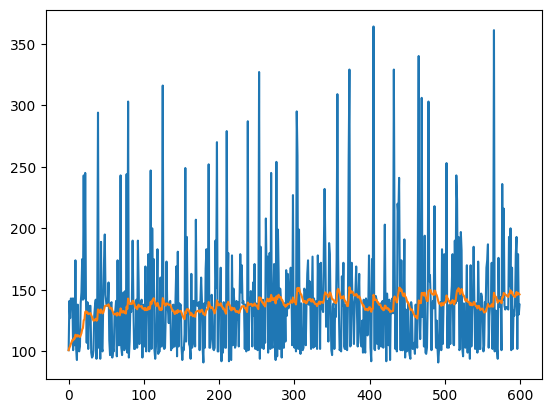

In [78]:
test_scores = test_agent(env, q_network, TEST_DURATION, TEST_EPOCHS)
visualize_scores(test_scores)

## Simulate an episode

In [79]:
SIM_DURATION = 250

In [80]:
env = gym.make("CartPole-v1")
s, _ = env.reset()

In [81]:
states = []
actions = []

actions_taken = 0
while True:
    actions_taken += 1
    with torch.no_grad():
        a, q = choose_action(q_network, s, 0.0)

    actions.append(a)
    states.append(s)
    
    s, r, terminate = take_action(env, a)
    
    terminate = terminate or \
                (actions_taken == SIM_DURATION)        
    if terminate:
        break

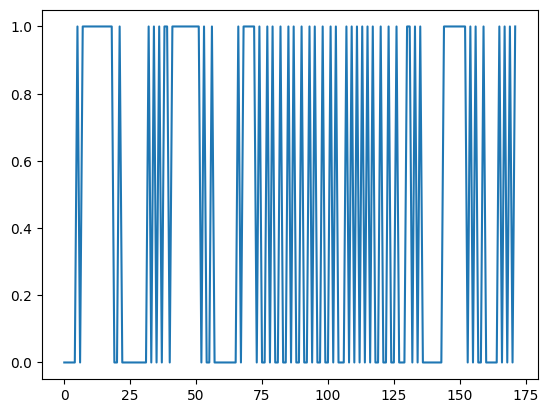

In [82]:
plt.plot(actions)

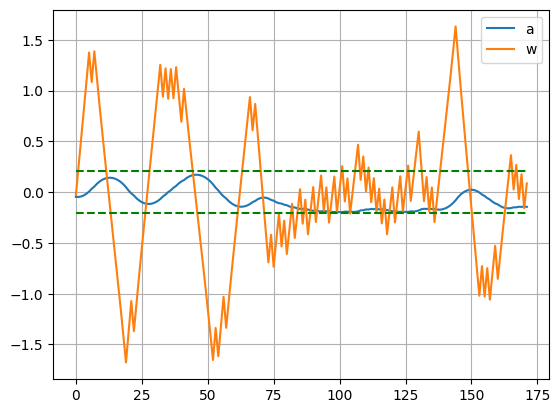

In [83]:
plt.plot([s[2] for s in states], label="a")
plt.plot([s[3] for s in states], label="w")
plt.plot(0.21*np.ones(len(actions)), "g--", label=None)
plt.plot(-0.21*np.ones(len(actions)), "g--", label=None)
plt.legend()
plt.grid()

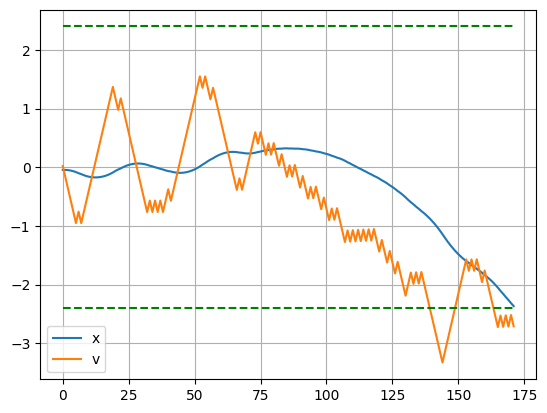

In [84]:
plt.plot([s[0] for s in states], label="x")
plt.plot([s[1] for s in states], label="v")
plt.plot(2.4*np.ones(len(actions)), "g--", label=None)
plt.plot(-2.4*np.ones(len(actions)), "g--", label=None)
plt.legend()
plt.grid()